## GANs : Generative Adversarial Networks 


Image from [here]()
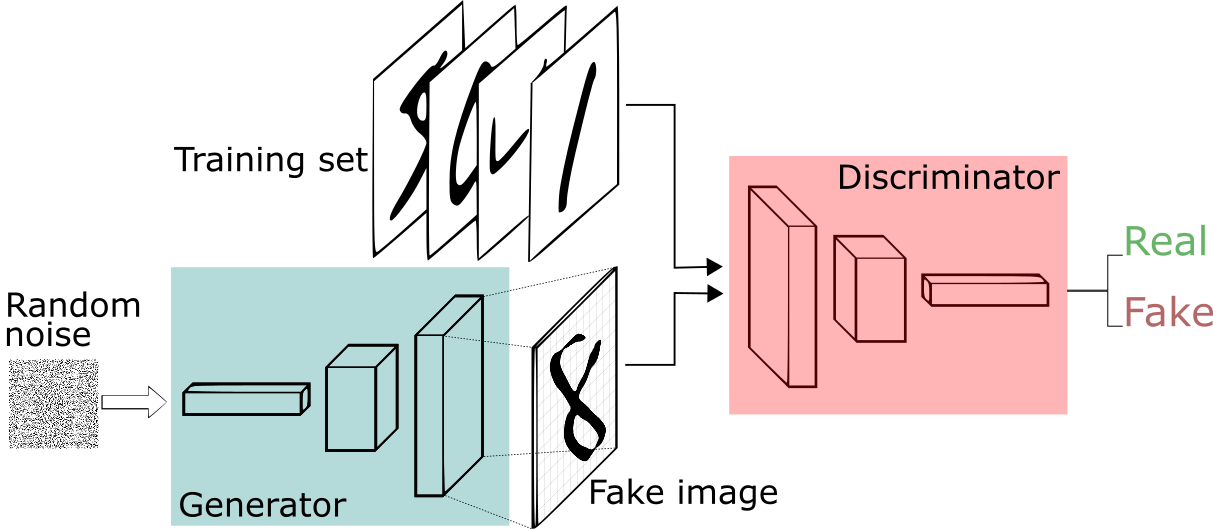

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


ModuleNotFoundError: No module named 'torch'


## Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        ################################
        # Please fill in your code here:
        ################################
        self.layers = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(100, 32, kernel_size=6),
            nn.LeakyReLU(0.2),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 1, kernel_size=8, dilation=2),
            nn.Tanh()
        )

        

    def forward(self, input):

        ################################
        # Please fill in your code here:
        ################################
        out = self.layers(input)

        # Explain why Tanh is needed for the last layer

        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        ################################
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=4, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1, 1, kernel_size=3, stride=2),
            nn.LeakyReLU(0.2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(36,1),
            nn.Sigmoid()
        )
        
    
    def forward(self, input):
        

        ################################
        # Please fill in your code here:
        ################################
        out = self.conv_layers(input)
        out = torch.flatten(out, start_dim=1)
        out = self.linear_layers(out)

        # Explain why Sigmoid is needed for the last layer
        
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


GAN loss (TODO)

In [ ]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    ################################
    # Please fill in your code here:
    ################################
    
    D.zero_grad()
    image_labels = D(real).view(-1)
    real_loss = criterion(image_labels, Valid_label)
    real_loss.backward()
    fake_imgs = G(noise)
    fake_image_labels = D(fake_imgs.detach()).view(-1)
    fake_loss = criterion(fake_image_labels, Fake_label)
    fake_loss.backward()
    loss_D = real_loss + fake_loss

    optimizerD.step()



    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    
    ################################
    # Please fill in your code here:
    ################################
    netG.zero_grad()
    fake_img_labels = netD(fake).view(-1)
    loss_G = criterion(fake_img_labels, Valid_label)
    loss_G.backward()
    optimizerG.step()
    
    return loss_G

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
UpsamplingBilinear2d-1            [-1, 100, 2, 2]               0
   ConvTranspose2d-2             [-1, 32, 7, 7]         115,232
         LeakyReLU-3             [-1, 32, 7, 7]               0
UpsamplingBilinear2d-4           [-1, 32, 14, 14]               0
   ConvTranspose2d-5            [-1, 1, 28, 28]           2,049
              Tanh-6            [-1, 1, 28, 28]               0
Total params: 117,281
Trainable params: 117,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.45
Estimated Total Size (MB): 0.53
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            

TRAINING

[0/10][0/600]	Loss_D: 1.3912	Loss_G: 0.7211	
[0/10][50/600]	Loss_D: 1.4319	Loss_G: 0.6705	
[0/10][100/600]	Loss_D: 1.4375	Loss_G: 0.6595	
[0/10][150/600]	Loss_D: 1.4359	Loss_G: 0.6604	
[0/10][200/600]	Loss_D: 1.4277	Loss_G: 0.6670	
[0/10][250/600]	Loss_D: 1.4196	Loss_G: 0.6729	
[0/10][300/600]	Loss_D: 1.4111	Loss_G: 0.6789	
[0/10][350/600]	Loss_D: 1.4038	Loss_G: 0.6849	
[0/10][400/600]	Loss_D: 1.3990	Loss_G: 0.6884	
[0/10][450/600]	Loss_D: 1.3954	Loss_G: 0.6910	
[0/10][500/600]	Loss_D: 1.3928	Loss_G: 0.6924	
[0/10][550/600]	Loss_D: 1.3909	Loss_G: 0.6936	
[1/10][0/600]	Loss_D: 1.3898	Loss_G: 0.6940	
[1/10][50/600]	Loss_D: 1.3889	Loss_G: 0.6943	
[1/10][100/600]	Loss_D: 1.3882	Loss_G: 0.6944	
[1/10][150/600]	Loss_D: 1.3876	Loss_G: 0.6946	
[1/10][200/600]	Loss_D: 1.3874	Loss_G: 0.6943	
[1/10][250/600]	Loss_D: 1.3870	Loss_G: 0.6939	
[1/10][300/600]	Loss_D: 1.3875	Loss_G: 0.6924	
[1/10][350/600]	Loss_D: 1.3871	Loss_G: 0.6921	
[1/10][400/600]	Loss_D: 1.3867	Loss_G: 0.6918	
[1/10][450/600]	Los

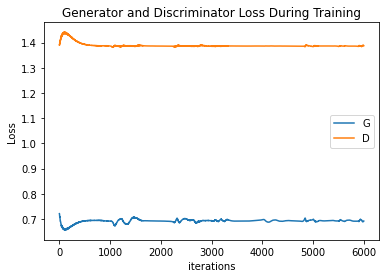

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

################################
# Please fill in your code here:

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

################################



img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ################################
        # Please fill in your code here:
        ################################
        loss_D, fake_images = loss_discriminator(netD, real, 
                                                 netG, noise, 
                                                 Valid_label, Fake_label, 
                                                 criterion, optimizerD)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        ################################
        # Please fill in your code here:
        ################################
        loss_G = loss_generator(netD, netG, 
                                fake_images, Valid_label, 
                                criterion, optimizerG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## Qualitative Visualisations

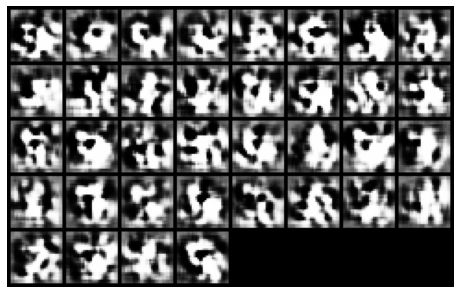

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())